In [1]:
using Pkg
Pkg.activate("/Users/briandepasquale/Documents/GitHub/zach_ssm_julia/")

  Activating project at `~/Documents/GitHub/zach_ssm_julia`


In [2]:
using Random
using SSM
using Distributions
using Plots
using StatsBase

In [3]:
"""
Generate Synthetic Exponential Kernels
"""

# generate data from a "switching gaussian regression"
n = 1000
K = 2
R = 100
X = Array{Matrix{Float64}}(undef, R)
S = Array{Vector{Float64}}(undef, R)
Y = Array{Vector{Float64}}(undef, R);

# Exponential

A = [0.9 0.1; 0.05 0.95]
β₁ = exp.(LinRange(-10, 0, 50)) ./ (sum(exp.(LinRange(-10, 0, 50)) * mean(diff(LinRange(-15, 0, 50)))))
β₂ = exp.(LinRange(-4, 0, 50)) ./ (sum(exp.(LinRange(-4, 0, 50)) * mean(diff(LinRange(-4, 0, 50)))))
σ²₁, σ²₂ = 1.0, 1.0;

init_state = Vector{Int}(undef, R)

for ii = 1:R

    x = cat(zeros(50), randn(n, 1), dims=1);
    XX = permutedims(hcat([x[i:i+50-1] for i in 1:n]...), (2,1))

    YY = zeros(n)
    SS = zeros(Int, n)
    
    for i in 1:n
        
        if i == 1
            SS[i] = StatsBase.sample(1:K, Weights([0.5, 0.5]))
            init_state[ii] = SS[i]
        else
            SS[i] = StatsBase.sample(1:K, Weights(A[SS[i-1], :]))
        end

        if SS[i] == 1
            YY[i] = XX[i, :]'*β₁ + rand(Normal(0, sqrt(σ²₁)))
        elseif SS[i] == 2
            YY[i] = XX[i, :]'*β₂ + rand(Normal(0, sqrt(σ²₂)))
        end
    end

    X[ii] = XX;
    Y[ii] = YY;
    S[ii] = SS;
end




In [4]:
function calculate_initial_state_probabilities(init_state::Vector{Int}, num_states::Int)
    state_counts = zeros(Int, num_states)
    total_trials = length(init_state)
    
    for state in init_state
        state_counts[state] += 1
    end
    
    initial_state_probabilities = state_counts / total_trials
    return initial_state_probabilities
end

# Example usage
num_states = 2  # Assuming there are 2 states
init_state_probabilities = calculate_initial_state_probabilities(init_state, num_states)
println("Initial state probabilities: ", init_state_probabilities)


Initial state probabilities: [0.52, 0.48]


In [5]:
model = SwitchingGaussianRegression(;K=2, λ=1e-12)
ll, A_stor, π_stor, β1_stor, β2_stor, σ1_stor, σ2_stor = SSM.fit!(model, X, Y, 75, 1e-12, true);

Log-Lieklihood at iter 1: -957441.7986861825
Log-Lieklihood at iter 2: -166082.36200258916
Log-Lieklihood at iter 3: -164556.42158115897
Log-Lieklihood at iter 4: -164175.18829029624
Log-Lieklihood at iter 5: -163255.91419986257
Log-Lieklihood at iter 6: -161482.5431533425
Log-Lieklihood at iter 7: -159161.5815143561
Log-Lieklihood at iter 8: -156997.93925981177
Log-Lieklihood at iter 9: -155329.37648767486
Log-Lieklihood at iter 10: -154103.14039918612
Log-Lieklihood at iter 11: -153185.22989085957
Log-Lieklihood at iter 12: -152490.20992834464
Log-Lieklihood at iter 13: -151970.9960247202
Log-Lieklihood at iter 14: -151592.93125164573
Log-Lieklihood at iter 15: -151325.33157765013
Log-Lieklihood at iter 16: -151141.32673745442
Log-Lieklihood at iter 17: -151018.55021454373
Log-Lieklihood at iter 18: -150939.13229056518
Log-Lieklihood at iter 19: -150889.31910925615
Log-Lieklihood at iter 20: -150858.96662604169
Log-Lieklihood at iter 21: -150840.94347816182
Log-Lieklihood at iter 22:

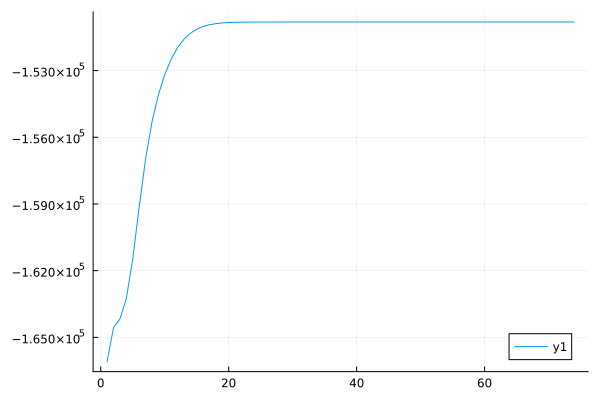

In [6]:
plot(ll[3:end])

In [11]:
all(diff(ll) .>0) 

true

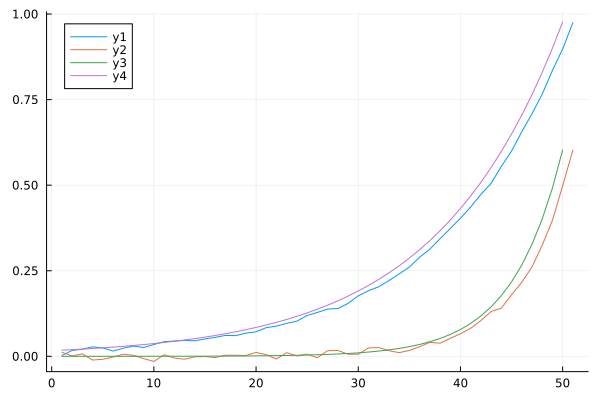

In [12]:
plot(model.B[1].regression.β)
plot!(model.B[2].regression.β)
plot!(β₁)
plot!(β₂)

In [13]:
println(model.πₖ)

[0.43187334572680247, 0.5681266542732025]


In [14]:
A

2×2 Matrix{Float64}:
 0.9   0.1
 0.05  0.95

In [15]:
model.A

2×2 Matrix{Float64}:
 0.950865  0.0491353
 0.101382  0.898618